# Problem Statement


## Introduction
When we are thinking about New York it is well known that the diversity in this city is one of the greatest in the world. This provides a great potential to new investors and as the diversity is great, the openness to new things is greater.

With a population of around 9 million, it did not have a great impact also during the COVID 19 pandemics. People are still open to new things, there is no fear from different and there is still a huge potential compared to other US cities / states.

In this final project we want to find the best location for German restaurants in New York and as there is a great immigration background, especially from Europe, there is great potential seen in this segment. We could find the tendency that European, especially Eastern European or Mediteranean restaurants are performing the best.

With a German place to eat out, we want to invest relatively safe but at the same time provide something different

## Data
To analyze the best place to invest in, the data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

## Methodology
• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by German restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Finally, the data be will be visually assessed using graphing from Python libraries.

## Problem Statement
What is the best location for German cuisine in New York City?
In what Neighborhood should we invest in order to have the best potential in success?
Where would I go in New York City to have the best German food?

The objective is to locate and recommend to the client which neighbourhood in New York City will be best choice to start a restaurant.

In [1]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [3]:

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In the next queries we will get Neighborhoods using FourSquare API & New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude.

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.



In [5]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'PQZV0ENKEPIUC4VSIYVFRAW2IDAMOBWXRI2BZNVVDHMVFFPP'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='JGJA1JRGLDVQSPMJ0GIZQVKJKPNXI4FEARMVILDJCV11D3OV' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get venue details like like count , rating , tip counts for a given venue id. to be used for ranking.



In [6]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'PQZV0ENKEPIUC4VSIYVFRAW2IDAMOBWXRI2BZNVVDHMVFFPP'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='JGJA1JRGLDVQSPMJ0GIZQVKJKPNXI4FEARMVILDJCV11D3OV' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a funtion to get the New York city data such as Boroughs, Neighborhoods along with their latitude and longitude.



In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
# get new york data
new_york_data=get_new_york_data()

In [9]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

We can observe that there are 306 neighborhoods in New York



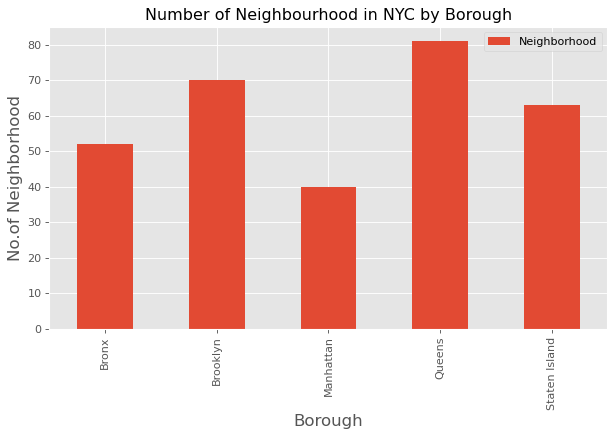

In [11]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

...and based on the data, the winner is Queens with the most densely populated borough in New York City with 80 neighborhoods



In the next Query we will provide/prepare a list of german restaurants

In [12]:
# prepare neighborhood list that contains german restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
german_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    german_resturants=venues[venues['Category']=='German Restaurant']   
    print('(',count,'/',len(new_york_data),')','German Resturants in '+Neighborhood+', '+Borough+':'+str(len(german_resturants)))
    for resturant_detail in german_resturants.values.tolist():
        id, name , category=resturant_detail
        german_rest_ny = german_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) German Resturants in Wakefield, Bronx:0
( 2 / 306 ) German Resturants in Co-op City, Bronx:0
( 3 / 306 ) German Resturants in Eastchester, Bronx:0
( 4 / 306 ) German Resturants in Fieldston, Bronx:0
( 5 / 306 ) German Resturants in Riverdale, Bronx:0
( 6 / 306 ) German Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) German Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) German Resturants in Woodlawn, Bronx:0
( 9 / 306 ) German Resturants in Norwood, Bronx:0
( 10 / 306 ) German Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) German Resturants in Baychester, Bronx:0
( 12 / 306 ) German Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) German Resturants in City Island, Bronx:0
( 14 / 306 ) German Resturants in Bedford Park, Bronx:0
( 15 / 306 ) German Resturants in University Heights, Bronx:0
( 16 / 306 ) German Resturants in Morris Heights, Bronx:0
( 17 / 306 ) German Resturants in Fordham, Bronx:0
( 18 / 306 ) German Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ger

In [13]:
german_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Cobble Hill,59e7f722829b0c09cfce96d2,Black Forest Brooklyn
1,Brooklyn,Carroll Gardens,59e7f722829b0c09cfce96d2,Black Forest Brooklyn
2,Brooklyn,Fort Greene,527c5b5d11d28f92bd96bc33,Black Forest Brooklyn
3,Brooklyn,Bath Beach,4e6c5541d1649db79994a95b,German Chocolate Cake
4,Brooklyn,Boerum Hill,59e7f722829b0c09cfce96d2,Black Forest Brooklyn


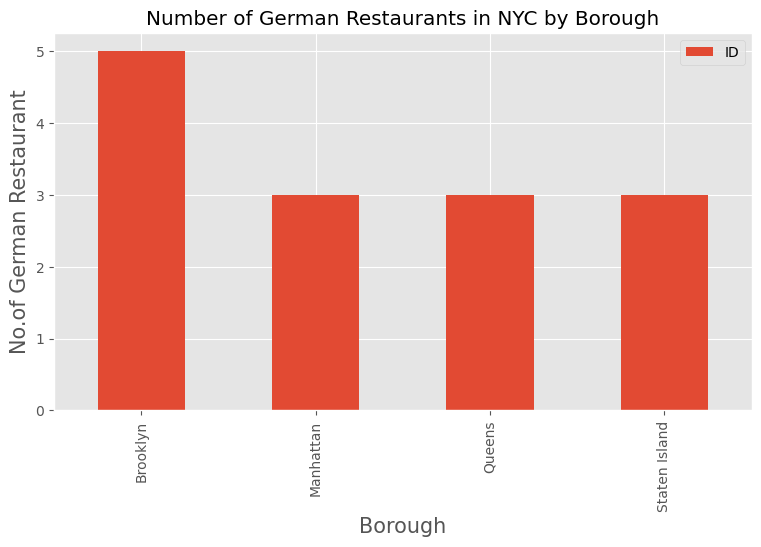

In [14]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of German Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of German Restaurant', fontsize=15)
#giving a bar plot
german_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [15]:
german_rest_ny[german_rest_ny['Neighborhood']=='Glendale']

,Borough,Neighborhood,ID,Name
7,Queens,Glendale,3fd66200f964a520fcf01ee3,Zum Stammtisch
8,Queens,Glendale,4ab427dff964a520227020e3,Manor Oktoberfest


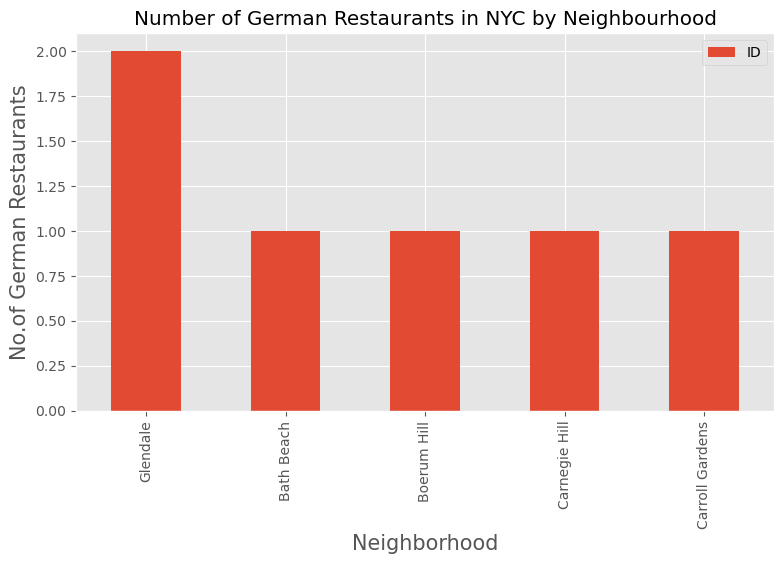

In [16]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of German Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of German Restaurants', fontsize=15)
#giving a bar plot
german_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Floral Park in Queens has the most German Resturants with a total count of 11.



In [17]:
# prepare neighborhood list that contains german resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
german_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in german_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains german resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
german_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in german_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(german_rest_ny),')','processed')
    german_rest_stats_ny = german_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                   Name  Likes  Rating  Tips
0  59e7f722829b0c09cfce96d2  Black Forest Brooklyn    103     8.9    12
( 1 / 14 ) processed
                         ID                   Name  Likes  Rating  Tips
0  59e7f722829b0c09cfce96d2  Black Forest Brooklyn    103     8.9    12
( 2 / 14 ) processed
                         ID                   Name  Likes  Rating  Tips
0  527c5b5d11d28f92bd96bc33  Black Forest Brooklyn    520     7.9   138
( 3 / 14 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4e6c5541d1649db79994a95b  German Chocolate Cake     22     7.4     0
( 4 / 14 ) processed
                         ID                   Name  Likes  Rating  Tips
0  59e7f722829b0c09cfce96d2  Black Forest Brooklyn    103     8.9    12
( 5 / 14 ) processed
                         ID                   Name  Likes  Rating  Tips
0  439e1fd8f964a520092c1fe3  Heidelberg Restaurant    254     8.8   104
( 6 / 14 ) processed
          

In [18]:
german_rest_stats_ny.shape

(14, 7)

In [19]:
german_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Cobble Hill,59e7f722829b0c09cfce96d2,Black Forest Brooklyn,103,8.9,12
1,Brooklyn,Carroll Gardens,59e7f722829b0c09cfce96d2,Black Forest Brooklyn,103,8.9,12
2,Brooklyn,Fort Greene,527c5b5d11d28f92bd96bc33,Black Forest Brooklyn,520,7.9,138
3,Brooklyn,Bath Beach,4e6c5541d1649db79994a95b,German Chocolate Cake,22,7.4,0
4,Brooklyn,Boerum Hill,59e7f722829b0c09cfce96d2,Black Forest Brooklyn,103,8.9,12


In [20]:
german_rest_stats_ny.to_csv('german_rest_stats_ny.csv', index=False)

In [21]:
german_rest_stats_ny_csv=pd.read_csv('german_rest_stats_ny.csv')

In [22]:
german_rest_stats_ny_csv.shape

(14, 7)

In [23]:
german_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Cobble Hill,59e7f722829b0c09cfce96d2,Black Forest Brooklyn,103,8.9,12
1,Brooklyn,Carroll Gardens,59e7f722829b0c09cfce96d2,Black Forest Brooklyn,103,8.9,12
2,Brooklyn,Fort Greene,527c5b5d11d28f92bd96bc33,Black Forest Brooklyn,520,7.9,138
3,Brooklyn,Bath Beach,4e6c5541d1649db79994a95b,German Chocolate Cake,22,7.4,0
4,Brooklyn,Boerum Hill,59e7f722829b0c09cfce96d2,Black Forest Brooklyn,103,8.9,12


In [24]:
german_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       14 non-null     object 
 1   Neighborhood  14 non-null     object 
 2   ID            14 non-null     object 
 3   Name          14 non-null     object 
 4   Likes         14 non-null     object 
 5   Rating        14 non-null     float64
 6   Tips          14 non-null     object 
dtypes: float64(1), object(6)
memory usage: 912.0+ bytes


In [25]:
# Restaurants with maximum Likes
german_rest_stats_ny.iloc[german_rest_stats_ny['Likes'].idxmax()]

TypeError: reduction operation 'argmax' not allowed for this dtype

In [26]:
# Restaurants with maximum Rating
german_rest_stats_ny.iloc[german_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Cobble Hill
ID              59e7f722829b0c09cfce96d2
Name               Black Forest Brooklyn
Likes                                103
Rating                               8.9
Tips                                  12
Name: 0, dtype: object

In [27]:
# Restaurants with maximum Tips
german_rest_stats_ny.iloc[german_rest_stats_ny['Tips'].idxmax()]

TypeError: reduction operation 'argmax' not allowed for this dtype

In [28]:
ny_neighborhood_stats=german_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [29]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
1,Boerum Hill,8.90
3,Carroll Gardens,8.90
5,Cobble Hill,8.90
2,Carnegie Hill,8.80
12,Yorkville,8.80
4,Charleston,8.00
7,Glendale,7.95
6,Fort Greene,7.90
9,Ridgewood,7.90
10,Turtle Bay,7.80


In [30]:
ny_borough_stats=german_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [31]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.466667
0,Brooklyn,8.400000
2,Queens,7.933333
3,Staten Island,7.666667


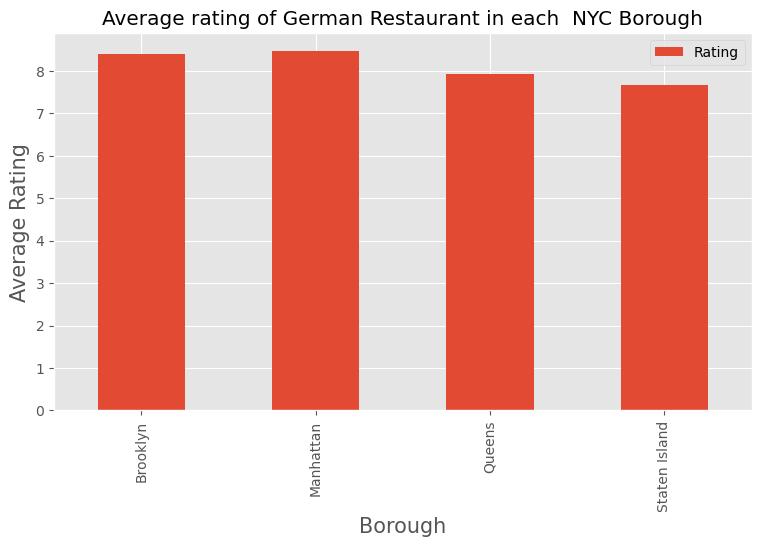

In [32]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of German Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
german_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Brooklyn has the highest average rating for German Restaurants.



All the neighborhoods with average rating greater or equal 7.0 to be visualized on map¶


In [33]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [34]:
ny_neighborhood_stats 

,Neighborhood,Average Rating
0,Bath Beach,7.40
1,Boerum Hill,8.90
2,Carnegie Hill,8.80
3,Carroll Gardens,8.90
4,Charleston,8.00
5,Cobble Hill,8.90
6,Fort Greene,7.90
7,Glendale,7.95
8,Randall Manor,7.50
9,Ridgewood,7.90


In [35]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [36]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]


In [37]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Borough,Neighborhood,Latitude,Longitude,Average Rating
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.90
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.90
5,Brooklyn,Cobble Hill,40.687920,-73.998561,8.90
2,Manhattan,Carnegie Hill,40.782683,-73.953256,8.80
12,Manhattan,Yorkville,40.775930,-73.947118,8.80
4,Staten Island,Charleston,40.530531,-74.232158,8.00
7,Queens,Glendale,40.702762,-73.870742,7.95
6,Brooklyn,Fort Greene,40.688527,-73.972906,7.90
9,Queens,Ridgewood,40.708323,-73.901435,7.90
10,Manhattan,Turtle Bay,40.752042,-73.967708,7.80


In [38]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [39]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [40]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

Best neighbourhoods in New York that has highest average rating for German Restaurants.¶


In [41]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Findings

Boerum Hill, Carroll Gardens, Cobble Hill in Brooklyn are some of the best neighborhoods for German cuisine.
Staten Islands has the lowest rated German Resturants in NYC.
However, Manhattan could be also a great potential to invest in German Cuisine.
# Recommendation
Cobble Hill or Carroll Gardens would be the best choice to start a restaurant 